In [1]:
# Goal: Develop simple parametric model for lightcurve interpolation and parameter extraction

In [2]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as table
import scipy.optimize as optimize

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.blackbody as blackbody
import snelib19odp.gaussian as gaussian
import snelib19odp.cauchy as cauchy
#import snelib19odp.synphot as synphot

In [3]:
# load the sn2019odp lc
ztf = table.Table.read('../data/ztflc_forcefit.h5')
ztf['mag'] = -2.5*np.log10(ztf['ampl']) + ztf['magzp']
ztf['phase'] = ztf['obsmjd'] - const.sne_peak_mjd['g']
ztf['mag_err'] = ztf['ampl.err']/ztf['ampl']*1.087 + ztf['magzprms']
ztf.sort('phase')
ztf

<ipython-input-3-b57c94e35122>:3: RuntimeWarning: invalid value encountered in log10
  ztf['mag'] = -2.5*np.log10(ztf['ampl']) + ztf['magzp']


<Table length=233>
      sigma             sigma.err      ...       mag_err      
     float64             float64       ...       float64      
------------------ ------------------- ... -------------------
 5.084136052596823 0.14598030314058213 ... -1.1490001230710076
 4.429017756876249 0.13089623320578814 ...  1.0381589988451725
7.5097771045959565 0.21343025115356465 ... -0.7547947551201604
 4.312240386808786 0.11895011491891837 ...  2.5157041991507145
 6.920073204906437 0.20183763719483674 ...  2.1821004353650575
 4.847475113950799 0.14199017641917233 ...  0.4469653311613376
 8.468640852051923 0.23663097108285228 ...  1.3565100213460677
5.7556202461528025 0.16507011574947664 ... -2.1560319138537545
10.685178556147084 0.11571123951332839 ... -13.747536344145171
12.701894355627289  0.3536305646637821 ...  4.6915097507565005
               ...                 ... ...                 ...
11.756126965829814 0.33270753646618856 ...  0.6155982828020776
10.508604769883636  0.2980412226697699 ...  0.9809188119046192
13.380180036161295 0.37292168647668056 ...  1.3017871286547738
15.854730822439397 0.46644715869210285 ...   3.400660029510126
 13.60963241181266 0.38560315389397826 ...  0.6281257876160395
 11.16743042466407  0.3051480017291456 ...  0.6804038803995662
 7.608362038731256 0.21204732924074718 ... 0.43183545547313457
 5.380505973919246  0.1545084515835955 ...  0.2866195515754014
 4.823029789358324 0.13353517841322923 ...  0.5464411689312635
 4.998202581685263 0.13419440737214583 ... 0.24093298030167937

In [70]:
plt.figure(figsize=(11,8))

band = 'g'
idx = np.logical_and(ztf['filter'] == ('ZTF_%s' % band),
                     np.logical_and(ztf['phase'] > -27, ztf['phase'] < 40))


t_peak = 0
gamma=1.0
g0 = 0.02
#model = (19.6 + gamma*t + g0 * np.exp(-(t)**2/2/10**2))/(1-np.exp(-20/10-t/10))

def modelfunc(p, t):
    f_0 = p[0]
    gamma = p[1]
    t_0 = p[2]
    t_1 = p[3]
    tau = p[4]
    g_0 = p[5]
    g_1 = p[6]
    theta = p[7]
    sigma_0 = p[8]
    sigma_1 = p[9]
    
    return (f_0 + gamma*(t-t_0) + g_0*np.exp(-(t-t_0)**2/2/sigma_0**2) + g_1*np.exp(-(t-t_1)**2/2/sigma_1**2))/(1-np.exp((tau-t)/theta))

def fitfunc(p, times, mags):
    model = modelfunc(p, times)
    return np.sum((mags-model)**2)

bounds = [
    (10, 20),
    (0.002, 0.040),
    (const.sne_peak_mjd['g'] -10, const.sne_peak_mjd['g']+10),
    (const.sne_peak_mjd['g'] +10, const.sne_peak_mjd['g']+32),
    (const.sne_peak_mjd['g'] -30, const.sne_peak_mjd['g']-10),
    (-5.1, 0.1),
    (-5.1, 0.1),
    (1, 10),
    (0.1, 30.1),
    (0.1, 30.1)
]
result = optimize.differential_evolution(fitfunc, bounds, args=(ztf['obsmjd'][idx], ztf['mag'][idx]), popsize=100, maxiter=3000)
print(result)



     fun: nan
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 3001231
     nit: 3000
 success: False
       x: array([ 1.75952103e+01,  3.41345064e-02,  5.87273553e+04,  5.87638087e+04,
        5.87156042e+04, -1.58758988e+00, -2.23606071e+00,  5.96400301e+00,
        2.37455762e+01,  1.84682904e+01])


<Figure size 792x576 with 0 Axes>

(0.0, 20.0)

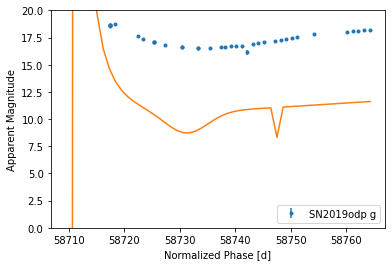

In [69]:
plt.errorbar(ztf['obsmjd'][idx], ztf['mag'][idx], yerr=ztf['mag_err'][idx], label='SN2019odp %s' % band, fmt='.')

plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Normalized Phase [d]')
plt.ylabel('Apparent Magnitude')

t = np.linspace(ztf['obsmjd'][idx].min(), ztf['obsmjd'][idx].max())

model = modelfunc(result.x, t)



plt.plot(t, model)
plt.ylim(0, 20)

In [35]:
# attempt fitting just the peak

band = 'r'
idx = np.logical_and(ztf['filter'] == ('ZTF_%s' % band),
                     np.logical_and(ztf['phase'] > -6, ztf['phase'] < 13))

def modelfunc(p, t):
    peak_mag = p[0]
    peak_mjd = p[1]
    peak_width = p[2]
    
    return 20-cauchy.cauchy(t, peak_mjd, peak_mag, peak_width)

def fitfunc(p, times, mags):
    model = modelfunc(p, times)
    return np.sum((mags-model)**2)

bounds = [
    (0, 400),
    (const.sne_peak_mjd['g'] -10, const.sne_peak_mjd['g']+10),
    (1, 60)
]

result = optimize.differential_evolution(fitfunc, bounds, args=(ztf['obsmjd'][idx], ztf['mag'][idx]))
print(result)

     fun: 0.009396932101038554
     jac: array([ 3.80251084e-06,  1.06681035e-06, -7.36927819e-06])
 message: 'Optimization terminated successfully.'
    nfev: 1464
     nit: 31
 success: True
       x: array([3.75936684e+02, 5.87384672e+04, 3.21262166e+01])


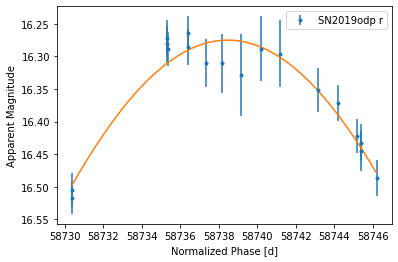

In [36]:
plt.errorbar(ztf['obsmjd'][idx], ztf['mag'][idx], yerr=ztf['mag_err'][idx], label='SN2019odp %s' % band, fmt='.')


plt.legend()
plt.xlabel('Normalized Phase [d]')
plt.ylabel('Apparent Magnitude')

t = np.linspace(ztf['obsmjd'][idx].min(), ztf['obsmjd'][idx].max())

model = modelfunc(result.x, t)



plt.plot(t, model)
#plt.ylim(0, 20)
plt.gca().invert_yaxis()

g 7 5.873424e+04 2.6e-01
g 9 5.873673e+04 1.0e+00
g 12 5.873574e+04 3.5e-01
g 14 5.873580e+04 1.4e-01
g 17 5.873581e+04 1.9e-01
g 19 5.873583e+04 1.7e-01
g 22 5.873589e+04 1.3e-01
g 24 5.873601e+04 8.9e-02
g 27 5.873601e+04 1.3e-01
g 30 5.873613e+04 1.2e-01
r 7 5.873747e+04 1.2e+00
r 9 5.873798e+04 4.3e-01
r 12 5.873866e+04 1.2e-01
r 14 5.873967e+04 7.4e-02
r 17 5.874031e+04 4.2e-02
r 19 5.874056e+04 1.1e-01
r 22 5.874075e+04 6.8e-02
r 24 5.874112e+04 6.9e-02
r 27 5.874193e+04 9.8e-02
r 30 5.874262e+04 6.5e-02
i 7 5.873850e+04 2.0e+00
i 9 5.873967e+04 5.1e-01
i 12 5.873864e+04 2.0e-01
i 14 5.874013e+04 1.7e-01
i 17 5.874014e+04 1.6e-01
i 19 5.874166e+04 2.1e-01
i 22 5.874154e+04 1.1e-01
i 24 5.874168e+04 1.6e-01
i 27 5.874154e+04 1.4e-01
i 30 5.874157e+04 1.3e-01


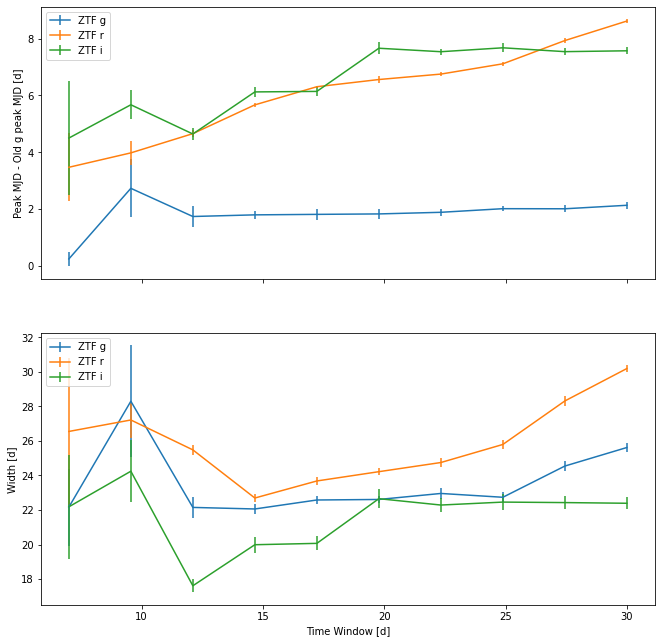

In [44]:
t_span = np.linspace(7, 30, 10)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(11,11))

num_impls = 11

for band in 'gri':
    fitted_peak_mjd = np.empty(len(t_span))
    fitted_width = np.empty(len(t_span))
    fitted_peak_mjd_err = np.empty(len(t_span))
    fitted_width_err = np.empty(len(t_span))

    for i, data_width in enumerate(t_span):
        impl_peak_mjd = np.empty(num_impls)
        impl_width = np.empty(num_impls)
        for j in range(num_impls):
            idx = np.logical_and(ztf['filter'] == ('ZTF_%s' % band),
                                 np.logical_and(ztf['phase'] > max(-14, -data_width), ztf['phase'] < data_width))
            rand_delete = np.random.randint(np.count_nonzero(idx))
            idx[idx][rand_delete] = False
            rand_delete = np.random.randint(np.count_nonzero(idx))
            idx[idx][rand_delete] = False
            rand_delete = np.random.randint(np.count_nonzero(idx))
            idx[idx][rand_delete] = False
            sample_mag = np.random.normal(ztf['mag'][idx], ztf['mag_err'][idx])
            #result = optimize.differential_evolution(fitfunc, bounds, args=(ztf['obsmjd'][idx], ztf['mag'][idx]))
            result = optimize.differential_evolution(fitfunc, bounds, args=(ztf['obsmjd'][idx], sample_mag))
            impl_peak_mjd[j] = result.x[1]
            impl_width[j] = result.x[2]
        fitted_peak_mjd[i] = np.mean(impl_peak_mjd)
        fitted_width[i] = np.mean(impl_width)
        fitted_peak_mjd_err[i] = np.std(impl_peak_mjd)
        fitted_width_err[i] = np.std(impl_width)
        print('%s %d %e %.1e' % (band, data_width, fitted_peak_mjd[i], fitted_peak_mjd_err[i]))
    ax1.errorbar(t_span, fitted_peak_mjd - const.sne_peak_mjd['g'], yerr=fitted_peak_mjd_err, label='ZTF %s' % band)
    ax2.errorbar(t_span, fitted_width, yerr=fitted_width_err, label='ZTF %s' % band)

ax2.set_xlabel('Time Window [d]')
ax1.set_ylabel('Peak MJD - Old g peak MJD [d]')
ax2.set_ylabel('Width [d]')
ax1.legend()
ax2.legend()